# An introduction to I-24 MOTION trajectory data

## Useful links
- I24 MOTION website: https://i24motion.org/
- Request for data access: https://i24motion.org/data
- Data documentation: https://github.com/I24-MOTION/I24M_documentation
- VT tools: https://github.com/I24-MOTION/VT_tools 
- Improvement tracker: https://github.com/I24-MOTION/I24M_improvement_tracker

## Directory structure
```
├── data_demo
│   ├── INCEPTION.22-11-22.tutorial.json
├── I24_tutorial_code
│   ├── intro_trajectory_data.ipynb
```

## This tutorial will cover:
- Load JSON file using an iterative JSON parser
- Trajectory data schema
- Compute derivative quantities (e.g., speed)
- Visualize a trajectory
- Plot a time-space diagram

## Import packages

In [1]:
import ijson
import os
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import datetime
from datetime import timezone, timedelta
import time


### Read a JSON file using an iterative JSON parser

In [2]:
# This data file contains approximately 41,000 trajectories
input_filename = "INCEPTION.22-11-22.tutorial.json"
file_path = os.path.join("../data_demo/", input_filename)

i = 0
# Select one trajectory from westbound that is more than 10 sec long
with open(file_path, 'r') as input_file:
    parser = ijson.items(input_file, 'item', use_float=True)
    for record in parser:
        if record["direction"] == -1 and (record["last_timestamp"] - record["first_timestamp"] > 10):
            print("Found a trajectory example")
            break

Found a trajectory example


In [3]:
print("TRAJECTORY KEYS:", list(record.keys()))
print("\n\n")
for key, val in record.items():
    if isinstance(val, list):
        print(f"{key}:   {val[:min(len(val), 20)]}")
    else:
        print(f"{key}:   {val}")

TRAJECTORY KEYS: ['_id', 'timestamp', 'x_position', 'y_position', 'road_segment_ids', 'flags', 'length', 'width', 'height', 'merged_ids', 'fragment_ids', 'coarse_vehicle_class', 'fine_vehicle_class', 'direction', 'compute_node_id', 'local_fragment_id', 'starting_x', 'first_timestamp', 'configuration_id', 'ending_x', 'last_timestamp', 'x_score', 'y_score']



_id:   {'$oid': '638bb843e38fd878abf4f6fe'}
timestamp:   [1669123189.1000004, 1669123189.1400003, 1669123189.1800003, 1669123189.2200003, 1669123189.2600005, 1669123189.3000004, 1669123189.3400004, 1669123189.3800004, 1669123189.4200003, 1669123189.4600003, 1669123189.5000005, 1669123189.5400004, 1669123189.5800004, 1669123189.6200004, 1669123189.6600003, 1669123189.7000003, 1669123189.7400002, 1669123189.7800004, 1669123189.8200004, 1669123189.8600004]
x_position:   [314836.96589700034, 314834.7395455097, 314832.5118186464, 314830.2827151683, 314828.05223264993, 314825.8203675603, 314823.5871153406, 314821.3524704818, 314819.11642

### Compute the derivative quantities

In [4]:
# Compute the longitudinal speed using numerical differentiation of the x_position, 
#   i.e., v = dx/dt. np.diff() computes the first-order numerical derivative.
# Multiply by record["direction"] to indicate the direction, 
#   i.e., negative speed means traveling westbound, and positive speed means traveling eastbound.
speed = np.diff(record["x_position"])/np.diff(record["timestamp"])*record["direction"]

# Speed array is truncated by one after the numerical differentiation np.diff(). 
# Append the first item to the array such that the speed array is the same length as the x_position array.
speed = np.append(speed[0], speed) 

# Convert unit from ft/sec to mph
speed *= 0.681818
# Convert unit from mph to kph
speed_kph = speed *  1.60934

# Print the first 10 records of speed
print(f"Speed (mph): {speed[:10]}")
print(f"Speed (kph): {speed_kph[:10]}")

Speed (mph): [37.94919921 37.94919921 37.97264308 37.99610812 38.01938789 38.04318107
 38.06682535 38.09056353 38.11441029 38.13837878]
Speed (kph): [61.07316425 61.07316425 61.11089341 61.14865664 61.1861217  61.22441303
 61.26246471 61.30066752 61.33904506 61.3776185 ]


In [5]:
# Similarly, compute the 2nd-order numerical differentiation of the x_position to obtain acceleration. 
# np.diff(record["x_position"], n=2) means the second order differentation of x_position.
# The unit for acceleration is ft/sec^2.
accel = np.diff(record["x_position"], n=2)/(np.diff(record["timestamp"][:-1])**2)*record["direction"]
print(f"Acceleration (ft/sec^2): {accel[:10]}")

Acceleration (ft/sec^2): [0.85960954 0.86038588 0.86190183 0.86409837 0.86695798 0.87040104
 0.87438231 0.87884546 0.88375831 0.88907717]


### Visualize a trajectory

In [6]:
import time

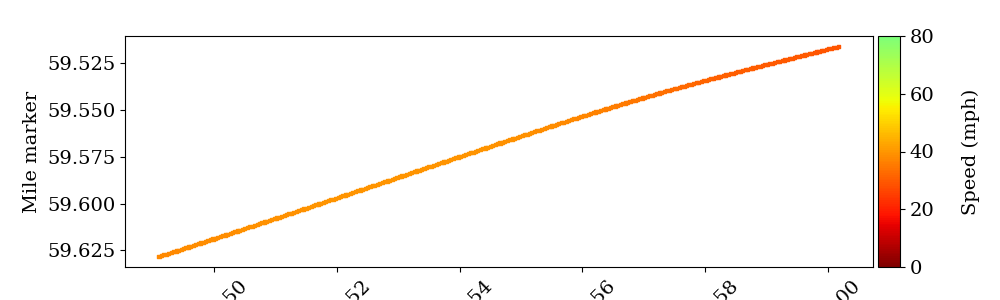

In [7]:
# Set up the plot
plt.rc('font', family='serif', size=14)
fig, ax = plt.subplots(figsize=(10,3))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)

# Define the color range
jet = plt.cm.jet
colors = [jet(x) for x in np.linspace(1, 0.5, 256)]
green_to_red = LinearSegmentedColormap.from_list('GreenToRed', colors, N=256)

# -------------------------------------------------------------------
# Plot the position (y-axis) vs. time (x-axis), colored by the speed.
# Position in ft is converted to mile-marker by dividing 5280.
trajectory_times = record["timestamp"]
trajectory_xvals = np.array(record["x_position"])/5280
im = ax.scatter(trajectory_times, trajectory_xvals, c=speed, cmap=green_to_red, vmin=0, vmax=80, marker ='s', s=5)
plt.colorbar(im, cax=cax).set_label('Speed (mph)', rotation=90, labelpad=20)
ax.set_xlabel("Time")
ax.set_ylabel("Mile marker")
# -------------------------------------------------------------------

# Update x-axis time to readable format
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
x_datetime = [datetime.datetime.fromtimestamp(ts) for ts in ticks_loc]
labels = [d.strftime('%H:%M:%S') for d in x_datetime]
ax.set_xticklabels(labels, rotation=45)

# Invert vertically
ax.invert_yaxis()


### Plot a time-space diagram (approx. 8:20-8:23 AM, Westbound)

Plotted 1000 trajectories
Plotted 2000 trajectories
Plotted 3000 trajectories
Plotted 4000 trajectories
Plotted 5000 trajectories
Elapsed: 18.698148012161255


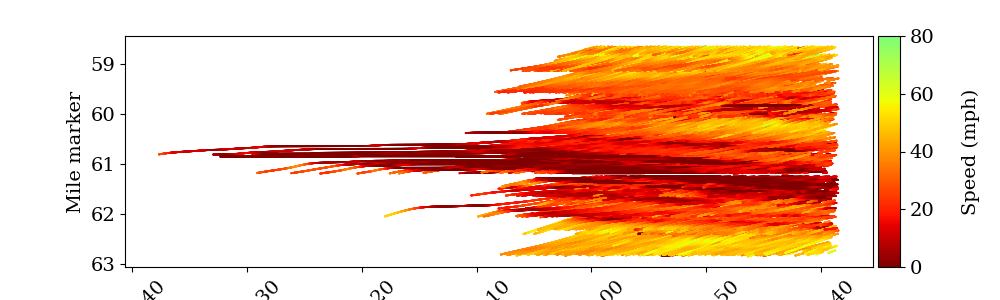

In [8]:
# Set up the plot
plt.rc('font', family='serif', size=14)
fig, ax = plt.subplots(figsize=(10,3))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)

# Define the color range
jet = plt.cm.jet
colors = [jet(x) for x in np.linspace(1, 0.5, 256)]
green_to_red = LinearSegmentedColormap.from_list('GreenToRed', colors, N=256)

# -------------------------------------------------------------------
# Iterate over each trajectory record across the file, compute the speed, and plot the position and speed simultaneously
# ijson allows us to read and plot each trajectory one by one instead of loading them all into the memory
t = time.time()
i = 0
with open(file_path, 'r') as input_file:
    parser = ijson.items(input_file, 'item', use_float=True)
    for record in parser:  
        # select westbound trajectories to plot
        if record["direction"] == -1: 
            position = np.array(record["x_position"]) / 5280
            speed = np.diff(record["x_position"]) / np.diff(record["timestamp"])
            speed = np.append(speed[0], speed)
            speed = -speed * 0.681818 # convert unit, and
            im = ax.scatter(record["timestamp"], position, c=speed, cmap=green_to_red, vmin=0, vmax=80, s=0.1)
            i += 1
            if i % 1000 == 0:
                print(f"Plotted {i} trajectories")
            if i > 5000:
                break
print(f"Elapsed: {time.time() - t}")
# -------------------------------------------------------------------

# Update colorbar and axes labels
plt.colorbar(im, cax=cax).set_label('Speed (mph)', rotation=90, labelpad=20)
ax.set_xlabel("Time")
ax.set_ylabel("Mile marker")

# Update x-axis time to readable format
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
x_datetime = [datetime.datetime.fromtimestamp(ts) for ts in ticks_loc]
labels = [d.strftime('%H:%M:%S') for d in x_datetime]
ax.set_xticklabels(labels, rotation=45)

# Invert vertically
ax.invert_yaxis()
plt.show()

#### In order to plot these additional data, you will need to download the appropriate file from i24motion.org/data using your account credentials. Download it to the same directory where you found `INCEPTION.22-11-22.tutorial.json`, or else change the path location.

In [32]:
import ijson
import os
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import datetime
from datetime import timezone, timedelta
import time
from collections import defaultdict
from matplotlib.patches import Rectangle

In [78]:
def summarize_congestion_by_mile(bucket_matrix, threshold, interval_minutes=10):
    # Group time buckets by spatial (mile) bucket
    mile_to_times = defaultdict(list)

    for (dt, mile), count in bucket_matrix.items():
        if count >= threshold:
            mile_to_times[mile].append(dt)

    summaries = []

    for mile in sorted(mile_to_times.keys()):
        times = sorted(mile_to_times[mile])

        if not times:
            continue

        start_time = times[0]
        prev_time = start_time

        for current_time in times[1:]:
            expected_next = prev_time + timedelta(minutes=interval_minutes)
            if current_time == expected_next:
                prev_time = current_time
            else:
                summaries.append({
                    "mile_start": mile,
                    "mile_end": mile + 0.5,  # Assuming mile_resolution = 0.5
                    "start_time": start_time,
                    "end_time": prev_time + timedelta(minutes=interval_minutes),
                })
                start_time = current_time
                prev_time = current_time

        # Add the final interval
        summaries.append({
            "mile_start": mile,
            "mile_end": mile + 0.5,
            "start_time": start_time,
            "end_time": prev_time + timedelta(minutes=interval_minutes),
        })

    return summaries


In [3]:
def extract_congested_trajectories(
    file_path, 
    traj_threshold_seconds=10,
    direction=-1
):
    found_trajectory = []
    date = None
    got_date = False

    with open(file_path, 'r') as input_file:
        parser = ijson.items(input_file, 'item', use_float=True)
        
        for record in parser:
            if record["direction"] == direction and (record["last_timestamp"] - record["first_timestamp"] > traj_threshold_seconds):

                #get date of file 
                if not got_date:
                    date = datetime.datetime.fromtimestamp(record["first_timestamp"]).date()
                    got_date = True

                #calc speed
                speed = np.diff(record["x_position"]) / np.diff(record["timestamp"]) * direction
                speed = np.append(speed[0], speed)
                speed *= 0.681818  # convert ft/s to mph

                if np.any((speed > 0) & (speed <= 20)):  # Check if speed ≤ 20 mph at any time, and above 0, i.e not parked
                    record["speed_mph"] = speed.tolist()
                    found_trajectory.append(record)

    print(f"{file_path}, {date} → Found {len(found_trajectory)} congested trajectories")
    return found_trajectory, date



                

In [4]:
def plot_congestion(found_trajectory, num_of_traj_to_plot=5000, bucket_counts=None):

    # Get min and max timestamp across all trajectories
    all_start_times = np.array([traj["first_timestamp"] for traj in found_trajectory])
    start_time = all_start_times.min()
    end_time = all_start_times.max()

    max_trajs = num_of_traj_to_plot

    # Sample or use all trajectories depending on total count
    total_trajs = len(found_trajectory)

    if total_trajs <= max_trajs:
        sampled_trajectories = found_trajectory
    else:
        indices = np.linspace(0, total_trajs - 1, max_trajs, dtype=int)
        sampled_trajectories = [found_trajectory[i] for i in indices]

    # Set up plot
    plt.rc('font', family='serif', size=14)
    fig, ax = plt.subplots(figsize=(10, 3))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05)

    # Define colormap (green to red)
    jet = plt.cm.jet
    colors = [jet(x) for x in np.linspace(1, 0.5, 256)]
    green_to_red = LinearSegmentedColormap.from_list('GreenToRed', colors, N=256)

    print("Plotting sampled trajectories...")

    t0 = time.time()
    for i, traj in enumerate(sampled_trajectories):
        position = np.array(traj["x_position"]) / 5280
        speed = np.array(traj["speed_mph"])
        timestamps = np.array(traj["timestamp"])

        im = ax.scatter(timestamps, position, c=speed, cmap=green_to_red, vmin=0, vmax=80, s=0.1)

        if len(sampled_trajectories) > 999:
            if (i + 1) % 1000 == 0:
                print(f"Plotted {i + 1} trajectories")
        else: 
            if (i + 1) % 100 == 0:
                print(f"Plotted {i + 1} trajectories")

    print(f"Elapsed: {time.time() - t0:.1f} seconds")

    # Colorbar and labels
    plt.colorbar(im, cax=cax).set_label('Speed (mph)', rotation=90, labelpad=20)
    ax.set_xlabel("Time")
    ax.set_ylabel("Mile marker")

    # Make timestamps readable on x-axis with Nashville timezone (UTC-6)
    ticks_loc = ax.get_xticks().tolist()
    ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    x_datetime = [datetime.datetime.fromtimestamp(ts, tz=timezone(timedelta(hours=-6))) for ts in ticks_loc]
    labels = [d.strftime('%H:%M:%S') for d in x_datetime]
    ax.set_xticklabels(labels, rotation=45)

    # Invert y-axis for westbound travel direction
    ax.invert_yaxis()

    # Plot vertical lines & top ticks only if bucket_counts given
    if bucket_counts is not None:
        bucket_timestamps = sorted([dt.timestamp() for dt in bucket_counts.keys()])
        bucket_timestamps = [ts for ts in bucket_timestamps if start_time <= ts <= end_time]

        for bucket_start_ts in bucket_timestamps:
            ax.axvline(x=bucket_start_ts, color='gray', linestyle='--', alpha=0.5, linewidth=0.8)

        ax_top = ax.twiny()
        counts = [bucket_counts[datetime.datetime.fromtimestamp(ts, tz=datetime.timezone(datetime.timedelta(hours=-6)))] for ts in bucket_timestamps]

        ax_top.set_xlim(ax.get_xlim())
        ax_top.set_xticks(bucket_timestamps)
        ax_top.set_xticklabels(counts, rotation=45, fontsize=8)
        ax_top.set_xlabel("Trajectories per bucket")

    plt.tight_layout()
    plt.show()


In [5]:
file_path = "/Users/Ludwig/Documents/GitHub/data_demo/637b023440527bf2daa5932f__post1.json"
trajs, date = extract_congested_trajectories(file_path)

/Users/Ludwig/Documents/GitHub/data_demo/637b023440527bf2daa5932f__post1.json, 2022-11-21 → Found 154038 congested trajectories


Plotting sampled trajectories...
Plotted 1000 trajectories
Plotted 2000 trajectories
Plotted 3000 trajectories
Plotted 4000 trajectories
Plotted 5000 trajectories
Elapsed: 28.7 seconds


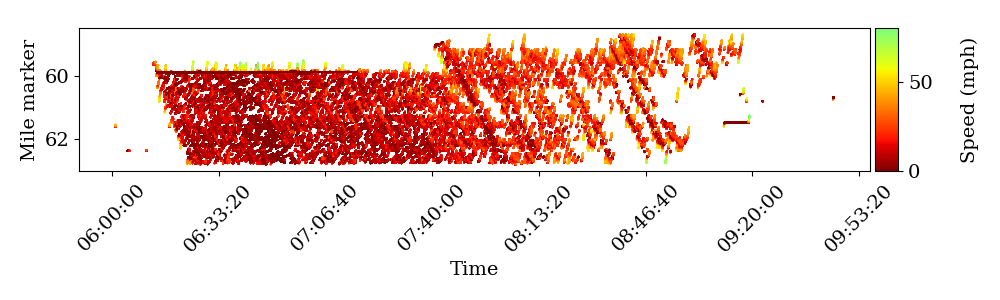

In [6]:
plot_congestion(trajs)

In [7]:
file_path2 = "/Users/Ludwig/Documents/GitHub/data_demo/637c399add50d54aa5af0cf4__post2.json"
trajs2, date2 = extract_congested_trajectories(file_path2)

/Users/Ludwig/Documents/GitHub/data_demo/637c399add50d54aa5af0cf4__post2.json, 2022-11-22 → Found 87695 congested trajectories


Plotting sampled trajectories...
Plotted 1000 trajectories
Plotted 2000 trajectories
Plotted 3000 trajectories
Plotted 4000 trajectories
Plotted 5000 trajectories
Elapsed: 136.8 seconds


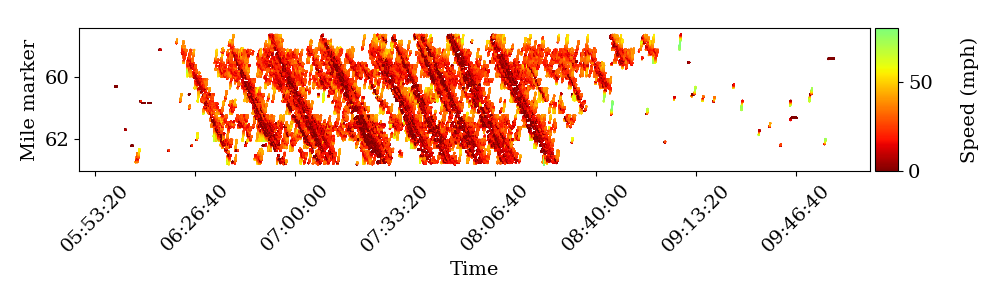

In [8]:
plot_congestion(trajs2)

In [9]:
file_path3 = "/Users/Ludwig/Documents/GitHub/data_demo/637d8ea678f0cb97981425dd__post3.json"
trajs3, date3 = extract_congested_trajectories(file_path3)

/Users/Ludwig/Documents/GitHub/data_demo/637d8ea678f0cb97981425dd__post3.json, 2022-11-23 → Found 21216 congested trajectories


Plotting sampled trajectories...
Plotted 1000 trajectories
Plotted 2000 trajectories
Plotted 3000 trajectories
Plotted 4000 trajectories
Plotted 5000 trajectories
Elapsed: 151.6 seconds


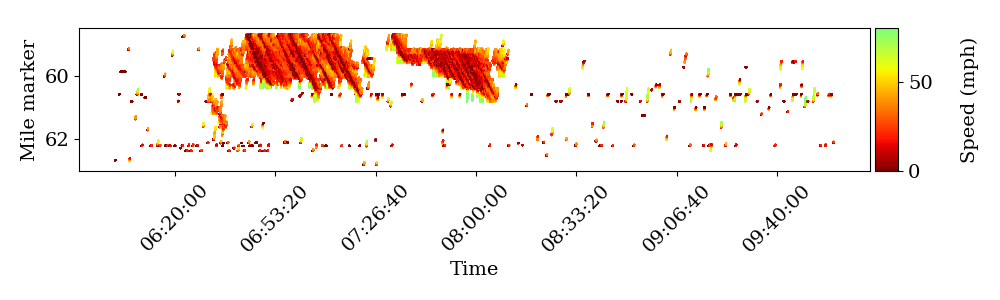

In [10]:
plot_congestion(trajs3)

In [11]:
file_path5 = "/Users/Ludwig/Documents/GitHub/data_demo/6380728cdd50d54aa5af0cf5__post5.json"
trajs5, date5 = extract_congested_trajectories(file_path5)

/Users/Ludwig/Documents/GitHub/data_demo/6380728cdd50d54aa5af0cf5__post5.json, 2022-11-25 → Found 1502 congested trajectories


Plotting sampled trajectories...
Plotted 1000 trajectories
Elapsed: 2.1 seconds


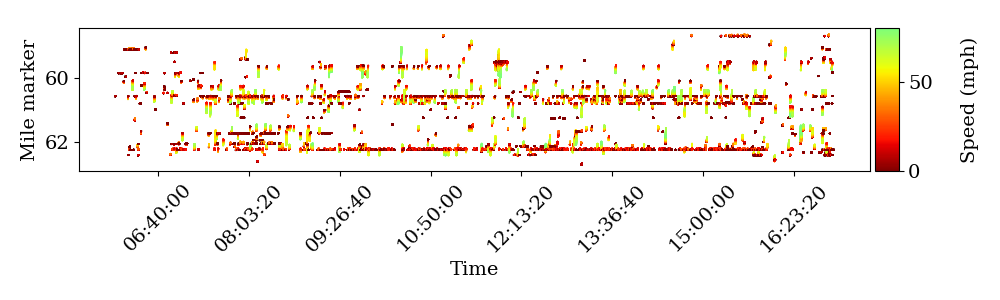

In [12]:
plot_congestion(trajs5)

In [ ]:
def bucket_trajectories_by_interval(found_trajectory, interval_minutes=1):
    """
    Buckets trajectories into time intervals of specified minutes.
    
    Args:
        found_trajectory (list): List of trajectory records.
        interval_minutes (int): Size of each time bucket in minutes.
        
    Returns:
        dict: {interval_start_datetime: count}
    """
    bucket_counts = defaultdict(int)
    interval = timedelta(minutes=interval_minutes)

    for traj in found_trajectory:
        # Round down first timestamp to the nearest interval
        first_ts = datetime.datetime.fromtimestamp(traj["first_timestamp"], tz=timezone(timedelta(hours=-6)))
        bucket_start = first_ts - timedelta(
            minutes=first_ts.minute % interval_minutes,
            seconds=first_ts.second,
            microseconds=first_ts.microsecond
        )
        bucket_counts[bucket_start] += 1

    print(f"Total trajectories: {len(found_trajectory)}")
    print(f"Total bucketed trajectories (sum of counts): {sum(bucket_counts.values())}")
    print(f"Number of buckets: {len(bucket_counts)}")
    
    return dict(bucket_counts), interval_minutes

In [17]:
minute_counts, interval_minutes = bucket_trajectories_by_interval(trajs, interval_minutes=10)
for minute, count in sorted(minute_counts.items()):
    if count >= 0:
        print(f"{minute.strftime('%Y-%m-%d %H:%M')} — {(minute + timedelta(minutes=interval_minutes)).strftime('%H:%M')} → {count} congested trajectories")




Total trajectories: 154038
Total bucketed trajectories (sum of counts): 154038
Number of buckets: 24
2022-11-21 06:00 — 06:10 → 60 congested trajectories
2022-11-21 06:10 — 06:20 → 2489 congested trajectories
2022-11-21 06:20 — 06:30 → 11175 congested trajectories
2022-11-21 06:30 — 06:40 → 12876 congested trajectories
2022-11-21 06:40 — 06:50 → 13117 congested trajectories
2022-11-21 06:50 — 07:00 → 12017 congested trajectories
2022-11-21 07:00 — 07:10 → 11429 congested trajectories
2022-11-21 07:10 — 07:20 → 11597 congested trajectories
2022-11-21 07:20 — 07:30 → 11733 congested trajectories
2022-11-21 07:30 — 07:40 → 11009 congested trajectories
2022-11-21 07:40 — 07:50 → 11864 congested trajectories
2022-11-21 07:50 — 08:00 → 10634 congested trajectories
2022-11-21 08:00 — 08:10 → 8786 congested trajectories
2022-11-21 08:10 — 08:20 → 6575 congested trajectories
2022-11-21 08:20 — 08:30 → 4759 congested trajectories
2022-11-21 08:30 — 08:40 → 4179 congested trajectories
2022-11-21 

hello world
Total trajectories: 154038
Total bucketed trajectories (sum of counts): 154038
Number of buckets: 48
Plotting sampled trajectories...
Plotted 1000 trajectories
Plotted 2000 trajectories
Plotted 3000 trajectories
Plotted 4000 trajectories
Plotted 5000 trajectories
Elapsed: 154.8 seconds


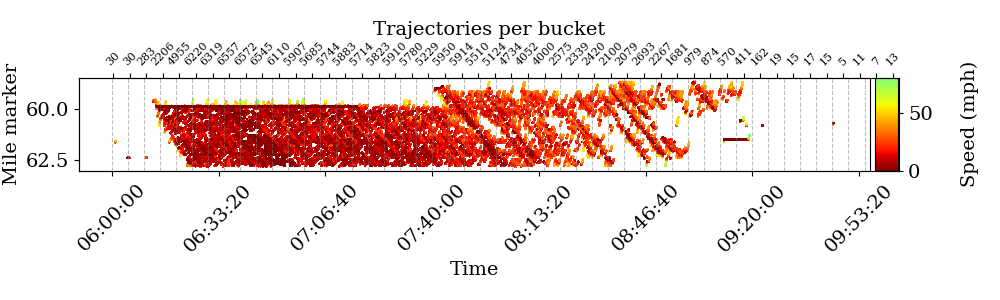

In [ ]:
buckets, interval_minutes = bucket_trajectories_by_interval(trajs, interval_minutes=5)
plot_congestion(trajs, num_of_traj_to_plot=5000, bucket_counts=buckets)

Total trajectories: 87695
Total bucketed trajectories (sum of counts): 87695
Number of buckets: 48
Plotting sampled trajectories...
Plotted 1000 trajectories
Plotted 2000 trajectories
Plotted 3000 trajectories
Plotted 4000 trajectories
Plotted 5000 trajectories
Elapsed: 15.0 seconds


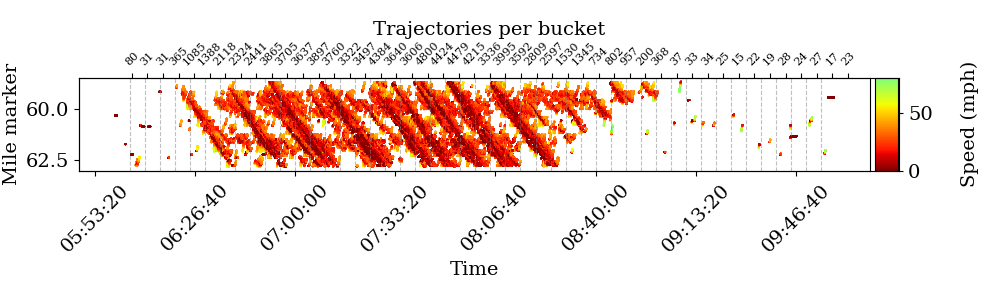

In [20]:
buckets2, interval_minutes = bucket_trajectories_by_interval(trajs2, interval_minutes=5)
plot_congestion(trajs2, num_of_traj_to_plot=5000, bucket_counts=buckets2)

Total trajectories: 1502
Total bucketed trajectories (sum of counts): 1502
Number of buckets: 130
Plotting sampled trajectories...
Plotted 1000 trajectories
Elapsed: 2.1 seconds


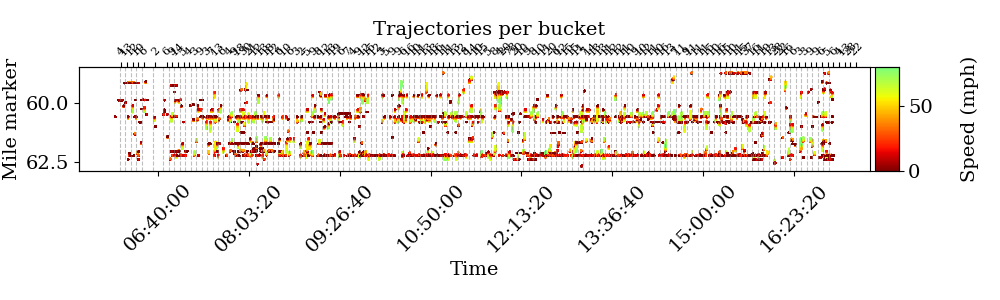

In [21]:
buckets5, interval_minutes = bucket_trajectories_by_interval(trajs5, interval_minutes=5)
plot_congestion(trajs5, num_of_traj_to_plot=5000, bucket_counts=buckets5)

In [22]:
def bucket_trajectories_time_and_space(found_trajectory, interval_minutes=1, mile_resolution=0.5):
    bucket_matrix = defaultdict(int)
    interval = timedelta(minutes=interval_minutes)

    for traj in found_trajectory:
        # --- Time bucketing (just like your existing function) ---
        first_ts = datetime.datetime.fromtimestamp(traj["first_timestamp"], tz=timezone(timedelta(hours=-6)))
        bucket_start = first_ts - timedelta(
            minutes=first_ts.minute % interval_minutes,
            seconds=first_ts.second,
            microseconds=first_ts.microsecond
        )

        # --- Space bucketing ---
        x_positions = np.array(traj["x_position"]) / 5280  # Convert feet to miles

        min_mile = np.min(x_positions)
        max_mile = np.max(x_positions)

        # Create 0.5-mile-aligned buckets (e.g., 2.0, 2.5, 3.0, ...)
        mile_bucket_start = np.floor(min_mile / mile_resolution) * mile_resolution
        mile_bucket_end = np.ceil(max_mile / mile_resolution) * mile_resolution

        current_mile = mile_bucket_start
        while current_mile < mile_bucket_end:
            bucket_key = (bucket_start, round(current_mile, 2))
            bucket_matrix[bucket_key] += 1
            current_mile += mile_resolution

    return bucket_matrix

In [71]:
def plot_congestion_new(
    found_trajectory, 
    num_of_traj_to_plot=5000, 
    bucket_counts=None, 
    bucket_matrix=None,
    mile_resolution=0.5,
    highlight_threshold=100,
    interval_minutes=10
):
    # Get min and max timestamp across all trajectories
    all_start_times = np.array([traj["first_timestamp"] for traj in found_trajectory])
    start_time = all_start_times.min()
    end_time = all_start_times.max()

    max_trajs = num_of_traj_to_plot
    total_trajs = len(found_trajectory)

    if total_trajs <= max_trajs:
        sampled_trajectories = found_trajectory
    else:
        indices = np.linspace(0, total_trajs - 1, max_trajs, dtype=int)
        sampled_trajectories = [found_trajectory[i] for i in indices]

    plt.rc('font', family='serif', size=14)
    fig, ax = plt.subplots(figsize=(10, 4))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05)

    jet = plt.cm.jet
    colors = [jet(x) for x in np.linspace(1, 0.5, 256)]
    green_to_red = LinearSegmentedColormap.from_list('GreenToRed', colors, N=256)

    print("Plotting sampled trajectories...")
    t0 = time.time()
    for i, traj in enumerate(sampled_trajectories):
        position = np.array(traj["x_position"]) / 5280
        speed = np.array(traj["speed_mph"])
        timestamps = np.array(traj["timestamp"])

        im = ax.scatter(timestamps, position, c=speed, cmap=green_to_red, vmin=0, vmax=80, s=0.1)

        if len(sampled_trajectories) > 999:
            if (i + 1) % 1000 == 0:
                print(f"Plotted {i + 1} trajectories")
        else:
            if (i + 1) % 100 == 0:
                print(f"Plotted {i + 1} trajectories")
    print(f"Elapsed: {time.time() - t0:.1f} seconds")

    # Colorbar and labels
    plt.colorbar(im, cax=cax).set_label('Speed (mph)', rotation=90, labelpad=20)
    ax.set_xlabel("Time")
    ax.set_ylabel("Mile marker")

    # X-axis: Format timestamps
    ticks_loc = ax.get_xticks().tolist()
    ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    x_datetime = [datetime.datetime.fromtimestamp(ts, tz=timezone(timedelta(hours=-6))) for ts in ticks_loc]
    labels = [d.strftime('%H:%M:%S') for d in x_datetime]
    ax.set_xticklabels(labels, rotation=45)

    # Invert y-axis (westbound direction)
    ax.invert_yaxis()

    # Add more y-axis (mile marker) ticks
    if bucket_matrix is not None:
        mile_markers = sorted(set(round(key[1], 2) for key in bucket_matrix.keys()))
        min_mile = min(mile_markers)
        max_mile = max(mile_markers)

        # Create ticks every 0.5 mile (or smaller if desired)
        y_ticks = np.arange(min_mile, max_mile + 0.01, 0.5)
        ax.set_yticks(y_ticks)

    # --- ⬛ Vertical lines for time buckets ---
    if bucket_counts is not None:
        bucket_timestamps = sorted([dt.timestamp() for dt in bucket_counts.keys()])
        bucket_timestamps = [ts for ts in bucket_timestamps if start_time <= ts <= end_time]

        for bucket_start_ts in bucket_timestamps:
            ax.axvline(bucket_start_ts, color="gray", linestyle="--", linewidth=0.3)

        # Optional: label bucket counts above plot
        ylim = ax.get_ylim()
        y_offset = (ylim[1] - ylim[0]) * 0.15  # Increased offset (was 0.05)
        for ts in bucket_timestamps:
            count = bucket_counts[datetime.datetime.fromtimestamp(ts, tz=timezone(timedelta(hours=-6)))]
            ax.text(
                ts,
                ylim[1] + y_offset,
                str(count),
                rotation=60,              # Tilt the label
                fontsize=8,
                color="gray",
                ha='center',
                va='bottom'
            )


    # --- ▬ Horizontal lines for space buckets ---
    if bucket_matrix is not None:
        # Extract unique mile markers from keys like: (datetime, mile)
        mile_markers = sorted(set(round(key[1], 2) for key in bucket_matrix.keys()))

        for mile in mile_markers:
            ax.axhline(mile, color="gray", linestyle="--", linewidth=0.3)

  
    if bucket_matrix is not None:
        print(f"Highlighting time-space buckets with ≥ {highlight_threshold} trajectories...")
        for (bucket_start_dt, mile_bucket), count in bucket_matrix.items():
            if count >= highlight_threshold:
                bucket_start_ts = bucket_start_dt.timestamp()
                rect = Rectangle(
                    (bucket_start_ts, mile_bucket),           # Bottom-left corner (x=time, y=mile)
                    interval_minutes * 60,                    # Width in seconds (since x-axis is timestamp)
                    mile_resolution,                          # Height in miles
                    linewidth=0,
                    facecolor='gray',
                    alpha=0.3
                )
                ax.add_patch(rect)

    
    plt.tight_layout()
    plt.show()


In [63]:
def print_highlighted_buckets(bucket_matrix, highlight_threshold=100):
 
    num_of_highlighted = 0
    for (bucket_start_dt, mile_bucket), count in bucket_matrix.items():
        if count >= highlight_threshold:
            num_of_highlighted += 1
            print(f"Time bucket start: {bucket_start_dt.strftime('%Y-%m-%d %H:%M')}, "
                  f"Mile marker bucket: {mile_bucket:.2f}, "
                  f"Trajectory count: {count}")
    print(f"Number of time-space buckets with ≥ {highlight_threshold} trajectories: {num_of_highlighted}")


Total trajectories: 154038
Total bucketed trajectories (sum of counts): 154038
Number of buckets: 24
Plotting sampled trajectories...
Plotted 1000 trajectories
Plotted 2000 trajectories
Plotted 3000 trajectories
Plotted 4000 trajectories
Plotted 5000 trajectories
Elapsed: 15.2 seconds
Highlighting time-space buckets with ≥ 100 trajectories...


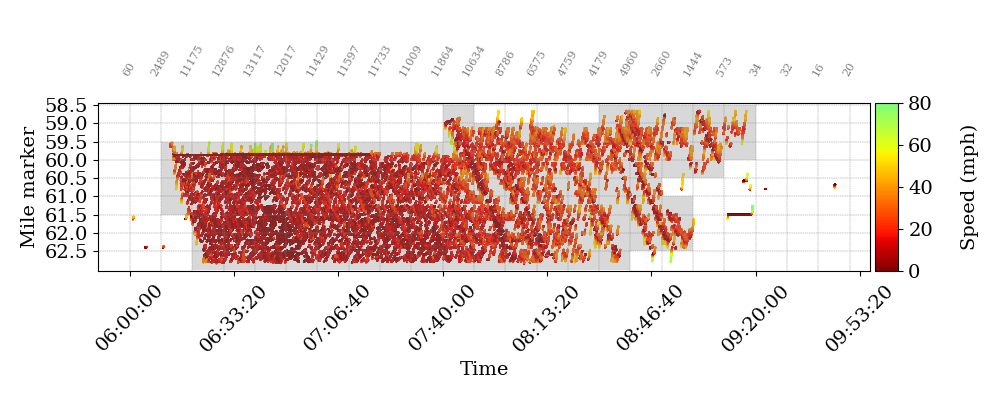

In [64]:
buckets_time, interval_minutes = bucket_trajectories_by_interval(trajs, interval_minutes=10)
buckets_space_time = bucket_trajectories_time_and_space(trajs, interval_minutes=10, mile_resolution=0.5)

plot_congestion_new(
    trajs,
    num_of_traj_to_plot=5000,
    bucket_counts=buckets_time,
    bucket_matrix=buckets_space_time
)


In [79]:
congestion_zones = summarize_congestion_by_mile(buckets_space_time, threshold=100, interval_minutes=10)

for zone in congestion_zones:
    print(
        f"Mile {zone['mile_start']}–{zone['mile_end']}: "
        f"{zone['start_time'].strftime('%H:%M')} → {zone['end_time'].strftime('%H:%M')}"
    )

print(f"\nTotal congestion intervals: {len(congestion_zones)}")


Mile 58.5–59.0: 07:40 → 07:50
Mile 58.5–59.0: 08:30 → 09:20
Mile 59.0–59.5: 07:40 → 09:20
Mile 59.5–60.0: 06:10 → 09:20
Mile 60.0–60.5: 06:10 → 09:10
Mile 60.5–61.0: 06:10 → 08:50
Mile 61.0–61.5: 06:10 → 09:00
Mile 61.5–62.0: 06:20 → 09:00
Mile 62.0–62.5: 06:20 → 09:00
Mile 62.5–63.0: 06:20 → 08:40

Total congestion intervals: 10


In [42]:
print_highlighted_buckets(buckets_space_time, highlight_threshold=100)

Time bucket start: 2022-11-21 06:10, Mile marker bucket: 60.50, Trajectory count: 922
Time bucket start: 2022-11-21 06:10, Mile marker bucket: 60.00, Trajectory count: 1017
Time bucket start: 2022-11-21 06:10, Mile marker bucket: 61.00, Trajectory count: 389
Time bucket start: 2022-11-21 06:10, Mile marker bucket: 59.50, Trajectory count: 505
Time bucket start: 2022-11-21 06:20, Mile marker bucket: 60.00, Trajectory count: 2021
Time bucket start: 2022-11-21 06:20, Mile marker bucket: 61.50, Trajectory count: 2636
Time bucket start: 2022-11-21 06:20, Mile marker bucket: 61.00, Trajectory count: 1919
Time bucket start: 2022-11-21 06:20, Mile marker bucket: 60.50, Trajectory count: 2471
Time bucket start: 2022-11-21 06:20, Mile marker bucket: 62.00, Trajectory count: 2249
Time bucket start: 2022-11-21 06:20, Mile marker bucket: 59.50, Trajectory count: 814
Time bucket start: 2022-11-21 06:20, Mile marker bucket: 62.50, Trajectory count: 715
Time bucket start: 2022-11-21 06:30, Mile marker

Total trajectories: 1502
Total bucketed trajectories (sum of counts): 1502
Number of buckets: 66
Plotting sampled trajectories...


/var/folders/_v/ljy6r6jx6vn86cq2rsw487bw0000gn/T/ipykernel_33140/3755664457.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 4))


Plotted 1000 trajectories
Elapsed: 2.1 seconds
Highlighting time-space buckets with ≥ 100 trajectories...


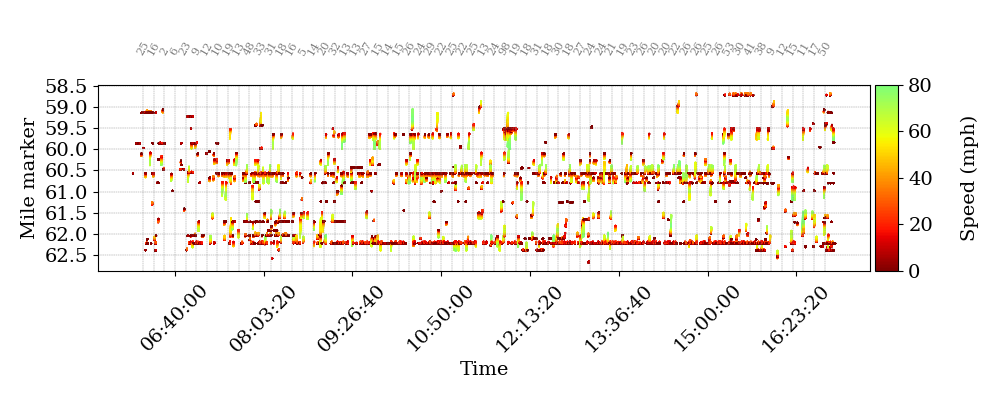

In [65]:
buckets_time5, interval_minutes5 = bucket_trajectories_by_interval(trajs5, interval_minutes=10)
buckets_space_time5 = bucket_trajectories_time_and_space(trajs5, interval_minutes=10, mile_resolution=0.5)

plot_congestion_new(
    trajs5,
    num_of_traj_to_plot=5000,
    bucket_counts=buckets_time5,
    bucket_matrix=buckets_space_time5,
    highlight_threshold=100
)

In [67]:
print_highlighted_buckets(buckets_space_time5, highlight_threshold=100)

Number of time-space buckets with ≥ 100 trajectories: 0


Total trajectories: 87695
Total bucketed trajectories (sum of counts): 87695
Number of buckets: 48
Plotting sampled trajectories...
Plotted 1000 trajectories
Plotted 2000 trajectories
Plotted 3000 trajectories
Plotted 4000 trajectories
Plotted 5000 trajectories
Elapsed: 15.2 seconds
Highlighting time-space buckets with ≥ 100 trajectories...


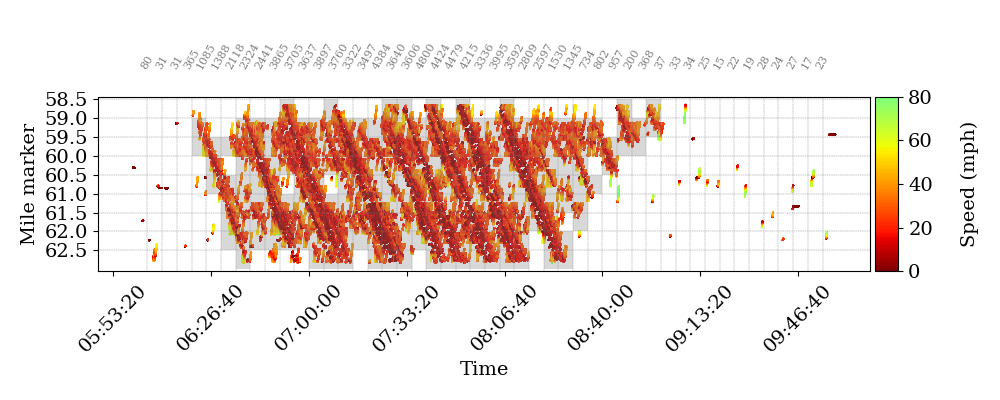

In [72]:
buckets_time2, interval_minutes2 = bucket_trajectories_by_interval(trajs2, interval_minutes=5)
buckets_space_time2 = bucket_trajectories_time_and_space(trajs2, interval_minutes=5, mile_resolution=0.5)

plot_congestion_new(
    trajs2,
    num_of_traj_to_plot=5000,
    bucket_counts=buckets_time2,
    bucket_matrix=buckets_space_time2,
    highlight_threshold=100,
    interval_minutes=5
)

In [77]:
def summarize_congestion_by_mile(bucket_matrix, threshold, interval_minutes=10):
    # Group time buckets by spatial (mile) bucket
    mile_to_times = defaultdict(list)

    for (dt, mile), count in bucket_matrix.items():
        if count >= threshold:
            mile_to_times[mile].append(dt)

    summaries = []

    for mile in sorted(mile_to_times.keys()):
        times = sorted(mile_to_times[mile])

        if not times:
            continue

        start_time = times[0]
        prev_time = start_time

        for current_time in times[1:]:
            expected_next = prev_time + timedelta(minutes=interval_minutes)
            if current_time == expected_next:
                prev_time = current_time
            else:
                summaries.append({
                    "mile_start": mile,
                    "mile_end": mile + 0.5,  # Assuming mile_resolution = 0.5
                    "start_time": start_time,
                    "end_time": prev_time + timedelta(minutes=interval_minutes),
                })
                start_time = current_time
                prev_time = current_time

        # Add the final interval
        summaries.append({
            "mile_start": mile,
            "mile_end": mile + 0.5,
            "start_time": start_time,
            "end_time": prev_time + timedelta(minutes=interval_minutes),
        })

    return summaries


In [75]:
congestion_zones = summarize_congestion_by_mile(buckets_space_time2, threshold=100, interval_minutes=5)

for zone in congestion_zones:
    print(
        f"Mile {zone['mile_start']}–{zone['mile_end']}: "
        f"{zone['start_time'].strftime('%H:%M')} → {zone['end_time'].strftime('%H:%M')}"
    )

print(f"\nTotal congestion intervals: {len(congestion_zones)}")


Mile 58.5–59.0: 06:50 → 06:55
Mile 58.5–59.0: 07:05 → 07:10
Mile 58.5–59.0: 07:25 → 07:35
Mile 58.5–59.0: 07:40 → 07:45
Mile 58.5–59.0: 07:50 → 07:55
Mile 58.5–59.0: 08:05 → 08:10
Mile 58.5–59.0: 08:45 → 08:50
Mile 58.5–59.0: 08:55 → 09:00
Mile 59.0–59.5: 06:20 → 06:25
Mile 59.0–59.5: 06:35 → 08:40
Mile 59.0–59.5: 08:45 → 09:00
Mile 59.5–60.0: 06:20 → 08:55
Mile 60.0–60.5: 06:25 → 06:30
Mile 60.0–60.5: 06:35 → 08:35
Mile 60.0–60.5: 08:40 → 08:45
Mile 60.5–61.0: 06:25 → 06:50
Mile 60.5–61.0: 06:55 → 07:05
Mile 60.5–61.0: 07:10 → 08:40
Mile 61.0–61.5: 06:30 → 08:35
Mile 61.5–62.0: 06:30 → 08:25
Mile 61.5–62.0: 08:30 → 08:35
Mile 62.0–62.5: 06:30 → 08:15
Mile 62.0–62.5: 08:20 → 08:30
Mile 62.5–63.0: 06:35 → 06:40
Mile 62.5–63.0: 07:00 → 07:15
Mile 62.5–63.0: 07:20 → 07:35
Mile 62.5–63.0: 07:40 → 08:15
Mile 62.5–63.0: 08:20 → 08:30

Total congestion intervals: 28


In [ ]:
print_highlighted_buckets(buckets_space_time2, highlight_threshold=100)

Multiple days (not correct anymore)

In [ ]:
def check_for_congestion(file_path, traj_threshold_seconds=60, congestion_threshold=200):
    date, found_trajectory = extract_congested_trajectories(
        file_path=file_path,
        traj_threshold_seconds=traj_threshold_seconds,
        direction=-1
    )
    num_congested = len(found_trajectory)
    congestion_detected = num_congested >= congestion_threshold
    return congestion_detected, date, found_trajectory



file_paths = [
    "/Users/Ludwig/Documents/GitHub/data_demo/637b023440527bf2daa5932f__post1.json",
    "/Users/Ludwig/Documents/GitHub/data_demo/637c399add50d54aa5af0cf4__post2.json",
    "/Users/Ludwig/Documents/GitHub/data_demo/637d8ea678f0cb97981425dd__post3.json",
    "/Users/Ludwig/Documents/GitHub/data_demo/6380728cdd50d54aa5af0cf5__post5.json",
]

for path in file_paths:
    congestion, date, found_trajectory = check_for_congestion(path, congestion_threshold=200)  # example threshold
    print(f"Date: {date} — Congestion detected: {congestion}")

/Users/Ludwig/Documents/GitHub/data_demo/637b023440527bf2daa5932f__post1.json: Found 14800 congested trajectories
Date: 2022-11-21 — Congestion detected: True
/Users/Ludwig/Documents/GitHub/data_demo/637c399add50d54aa5af0cf4__post2.json: Found 7677 congested trajectories
Date: 2022-11-22 — Congestion detected: True
/Users/Ludwig/Documents/GitHub/data_demo/6380728cdd50d54aa5af0cf5__post5.json: Found 67 congested trajectories
Date: 2022-11-25 — Congestion detected: False
